In [1]:
%config Completer.use_jedi = False

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK50_4"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}



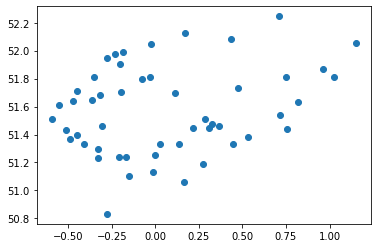

In [28]:
plt.scatter(points_coordinate[:,1],points_coordinate[:,0])

In [31]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[]}


amount_of_runs = 1
amount_of_evaluations = 5000
logpath = "parameter_data/{}".format(dataset)
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})


In [30]:
logpath

'parameter_data/UK50_4'

# Paremeter Test 

# Simulated Annealing

In [29]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = []
for x in mutation_arange:
    parameter_list_SA.append({"mutation":np.round(x,2)})



parameter_data_SA = []
computation_times_SA = []
results_SA = []
sa_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_SA):
    plot_data_SA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
       
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()        
        store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_SA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)#["Parameters"] = param
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    sa_log_data_DF = pd.concat([sa_log_data_DF,new_Row])
    
    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})

sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:150 of 150
Evaluations: 10000/10000
Params: {'mutation': 0.9}
IGD:2320.2859125711884
Best fitness: 500.0653                          
Best total fuel consumption:256.78 
Best total drive time:2306.03                          
Computing time: 16.94s
Average computing speed: 590.46it/s                          
Current Route:[['V0', 70, 24, 36, 66, 11, 32], ['V3', 3, 72, 59, 29, 71, 57, 39, 18, 5], ['V12', 23, 74, 53, 5], ['V4', 34, 13, 7, 65, 64, 48, 62, 1], ['V8', 46, 50, 8, 43, 26, 2], ['V6', 14, 73, 58, 51, 20], ['V7', 12, 54, 37, 19, 2], ['V2', 30, 47, 9, 5], ['V11', 55, 4], ['V1', 17, 56, 27, 22, 20], ['V13', 42, 69, 75, 5], ['V14', 44, 2], ['V15', 16, 63, 2], ['V18', 25, 28, 49, 52, 33, 38, 61, 41, 4], ['V19', 67, 4]]
Flags: []
Violation:0
Vehicle Amount:15


In [31]:
#sa_log_data_DF.to_csv("{}/SA.csv".format(logpath))

# Genetic Algorithm

In [7]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameter_list_GA = genetic_algorithms_parameters

GA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))

for index,param in enumerate(parameter_list_GA):
    plot_data_GA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_GA = VRP(data_model_input_single_objective)
        problem_GA.name = "GA"
        problem_GA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                        population_size=param["population_size"],
                        offspring_population_size=param["population_size"],
                        mutation=PermutationSwapMutation(param["mutation"]),
                        crossover=PMXCrossover(param["crossover"]),
                        selection=BestSolutionSelection(),
                        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                        ,population_evaluator=MultiprocessEvaluator()
                        )


        performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_GA)
        performance_observer_GA.maxEpochs= len(parameter_list_GA) * amount_of_runs
        performance_observer_GA.currentEpoch = (index*amount_of_runs) + x
        algorithm_GA.observable.register(observer=performance_observer_GA)
        start_time = datetime.now() 
        algorithm_GA.run()
        run_time = datetime.now() - start_time
        solutions_GA = algorithm_GA.get_result()
        

        store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_GA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    GA_log_data_DF = pd.concat([GA_log_data_DF,new_Row])
    

#saveParameterData(logPath,"GA_data_10_pop",parameter_data_GA)

Epoch:1 of 1
Evaluations: 10000/10000
Params: {'mutation': 0.8, 'crossover': 0.5, 'population_size': 20}
IGD:2693.7976115766787
Best fitness: 1260.0176                          
Best total fuel consumption:345.68 
Best total drive time:2513.22                          
Computing time: 12.55s
Average computing speed: 796.6it/s                          
Current Route:[['V1', 64, 14, 8, 28, 45], ['V0', 43, 5], ['V5', 56, 9, 58, 11, 55, 30, 48, 2], ['V4', 61, 3, 71, 74, 16, 62, 52, 4], ['V6', 29, 38, 19, 59, 39, 45], ['V8', 69, 32], ['V9', 37, 25, 23, 50, 34, 13, 54, 46, 75, 4], ['V12', 22, 72, 45], ['V10', 51, 47, 7, 20], ['V14', 53, 45], ['V2', 44, 24, 20], ['V16', 18, 42, 65, 17, 36, 41, 49, 5], ['V18', 33, 57, 70, 26, 63, 67, 73, 66, 2], ['V19', 12, 27, 45]]
Flags: ['overload']
Violation:-624.0
Vehicle Amount:14


In [ ]:
#GA_log_data_DF.to_csv("{}/GA.csv".format(logpath))

In [17]:
def euclidean_distance_to_origin(x):
        return (x[0]**2 + x[1]**2)**0.5

# NSGA-II

In [44]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_NSGAII = [{"mutation":0.8,"crossover":0.5,"population_size":30}]#,{"mutation":0.8,"crossover":0.5}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAII.append({"mutation":round(x,2),"crossover":round(y,2)})


NSGA2_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAII):
    plot_data_NSGAII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_NSGAII = VRP(data_model_input_multi_objective)
        problem_NSGAII.name = "NSGA-II"
        problem_NSGAII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator()

                                   )

        performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=60,params=parameter_list_NSGAII)
        performance_observer_NSGAII.maxEpochs= len(parameter_list_NSGAII) * amount_of_runs
        performance_observer_NSGAII.currentEpoch = (index*amount_of_runs) + x
        
        
        
        algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
        algorithm_NSGAII.run()
        
        solutions_NSGAII = algorithm_NSGAII.get_result()
        front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
        front_2 = sorted(solutions_NSGAII,key=lambda solution: euclidean_distance_to_origin(solution.objectives))[0]
        
        store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])
        store_plot_data(plot_data_NSGAII2,performance_observer_NSGAII2,front_2)
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA2_log_data_DF = pd.concat([NSGA2_log_data_DF,new_Row])



Epoch:1 of 1
Evaluations: 5010/5000
Params: {'mutation': 0.8, 'crossover': 0.5, 'population_size': 30} 
IGD:290.00816485074716
Best fitness: 195.528 --- 218.0                        
Best total fuel consumption:195.53 
Computing time: 5.07s                        
Average computing speed: 988.39it/s
Current Route:[['V0', 47, 9, 32], ['V2', 8, 39, 32], ['V3', 22, 33, 25, 32], ['V4', 12, 28, 20], ['V5', 36, 41, 42, 20], ['V6', 46, 27, 44, 43, 31, 30, 5], ['V7', 16, 3, 37, 11, 13, 1], ['V10', 48, 24, 38, 14, 50, 34, 19, 20], ['V12', 29, 32], ['V13', 23, 17, 26, 18, 49, 7, 1]]
Flags: []                        
Violation:0
Vehicle amount:10


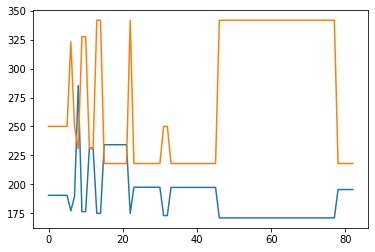

In [48]:
plt.plot(plot_data_NSGAII["fitness"][0])

In [ ]:
#NSGA2_log_data_DF.to_csv("{}/NSGA2.csv".format(logpath))

# NSGA-III

In [ ]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = genetic_algorithms_parameters

NSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA3_log_data_DF = pd.concat([NSGA3_log_data_DF,new_Row])
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


In [ ]:
#NSGA3_log_data_DF.to_csv("{}/NSGA3.csv".format(logpath))

# UNSGA-III

In [8]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_UNSGAIII = [{"mutation":0.7,"crossover":0.75,"population_size":100}]#,{"mutation":0.8,"crossover":0.5}]#genetic_algorithms_parameters
UNSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_UNSGAIII):
    plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_UNSGAIII = VRP(data_model_input_multi_objective)
        problem_UNSGAIII.name = "NSGA-III"
        problem_UNSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_UNSGAIII)
        performance_observer_UNSGAIII.maxEpochs= len(parameter_list_UNSGAIII) * amount_of_runs
        performance_observer_UNSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
        algorithm_UNSGAIII.run()
        
        solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
        front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
        
        store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_UNSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    UNSGA3_log_data_DF = pd.concat([UNSGA3_log_data_DF,new_Row])
        
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:1350 of 1350
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:356.7472091272461
Best fitness: 240.1507 --- 312.5333                        
Best total fuel consumption:240.15 
Computing time: 14.6s                        
Average computing speed: 686.15it/s
Current Route:[['V0', 17, 24, 3, 70, 32], ['V2', 59, 29, 32], ['V3', 72, 30, 71, 57, 39, 47, 18, 74, 23, 53, 5], ['V4', 34, 13, 7, 65, 64, 48, 62, 1], ['V8', 46, 50, 8, 43, 26, 2], ['V6', 11, 66, 14, 73, 58, 51, 20], ['V7', 12, 54, 37, 19, 2], ['V10', 55, 4], ['V12', 36, 75, 69, 56, 27, 22, 20], ['V13', 42, 9, 5], ['V14', 44, 2], ['V15', 16, 63, 2], ['V18', 25, 28, 49, 52, 33, 38, 61, 41, 4], ['V19', 67, 4]]
Flags: []                        
Violation:0
Vehicle amount:14


Process ForkPoolWorker-21594:
Process ForkPoolWorker-21600:
Process ForkPoolWorker-21593:
Process ForkPoolWorker-21595:
Process ForkPoolWorker-21596:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):


In [9]:
#UNSGA3_log_data_DF.to_csv("{}/UNSGA3.csv".format(logpath))

# IBEA

In [ ]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_IBEA =genetic_algorithms_parameters

IBEA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_IBEA = VRP(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_IBEA = IBEA(problem=problem_IBEA,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                kappa =1,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * amount_of_runs
        performance_observer_IBEA.currentEpoch = (index*amount_of_runs) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])
    
    new_Row = pd.DataFrame.from_dict(plot_data_IBEA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    IBEA_log_data_DF = pd.concat([IBEA_log_data_DF,new_Row])
    
    
ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:802 of 1350
Evaluations: 8190/10000
Params: {'mutation': 0.5, 'crossover': 0.75, 'population_size': 30} 
IGD:1032.236643802942
Best fitness: 980.4271 --- 322.9167                        
Best total fuel consumption:980.43 
Computing time: 23.49s                        
Average computing speed: 348.68it/s
Current Route:[['V14', 28, 8, 37, 32], ['V1', 64, 14, 53, 45], ['V5', 58, 55, 11, 48, 2], ['V4', 56, 61, 3, 71, 74, 16, 9, 62, 52, 4], ['V7', 72, 29, 39, 59, 19, 45], ['V9', 69, 32], ['V15', 50, 54, 13, 5], ['V0', 25, 23, 75, 46, 34, 5], ['V11', 38, 51, 47, 7, 44, 24, 30, 2], ['V12', 22, 45], ['V8', 43, 5], ['V16', 18, 42, 65, 17, 36, 41, 49, 5], ['V18', 33, 57, 70, 26, 63, 67, 73, 66, 2], ['V19', 12, 27, 45]]
Flags: ['overload']                        
Violation:-624.0
Vehicle amount:14


Process ForkPoolWorker-28016:
Process ForkPoolWorker-28015:
Process ForkPoolWorker-28011:
Traceback (most recent call last):
Process ForkPoolWorker-28010:
Process ForkPoolWorker-28014:
Process ForkPoolWorker-28012:
Process ForkPoolWorker-28009:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-28013:


In [77]:
#IBEA_log_data_DF.to_csv("{}/IBEA.csv".format(logpath))

In [17]:
#sa_log_data_DF.to_csv("{}/SA.csv".format(logpath))

In [ ]:
#sa_log_data_DF.to_csv("{}/SA.csv".format(logpath))